In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from IPython.display import HTML
import numpy as np
from skimage import measure

In [2]:
def Abs_sobel_thresh(image,orient='x',thresh=(40,250) ,sobel_kernel=3):
    gray=image#cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        #the operator calculates the derivatives of the pixel values along the horizontal direction to make a filter.
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize= sobel_kernel) 
    if (orient=='y'):
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize= sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled_sobel=(255*abs_sobel/np.max(abs_sobel))
    grad_binary=np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return grad_binary



def Mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=image#cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)

    gradmag=np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag=np.uint8(gradmag/scale_factor )
    mag_binary=np.zeros_like(gradmag)
    mag_binary[(gradmag>=mag_thresh[0])&(gradmag<=mag_thresh[1])]=1
    # Apply threshold
    return mag_binary

def Dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=image#cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    abs_graddir=np.arctan(abs_sobely,abs_sobelx)
    dir_binary=np.zeros_like(abs_graddir)
    dir_binary[(abs_graddir>=thresh[0])&(abs_graddir<=thresh[1])]=1
    # Calculate gradient direction
    # Apply threshold
    return dir_binary
def Combined_thresholds(gradx,grady,mag_binary,dir_binary):
    combined=np.zeros_like(dir_binary)
    combined[(gradx==1)|(grady==1) |(mag_binary==1)|(dir_binary==1)]=1
    return combined
    

def BilateralFilter(image, kernel_size,sigmaSpace,sigmaColor): # bilateral filter can keep edges sharp while removing noises
    img=np.copy(image)
    img=cv2.bilateralFilter(img,kernel_size,sigmaColor,sigmaSpace)
    #plt.imshow(img)
    return img
def Closing(image,k):# closing is useful to detect the overall contour of a figure and opening is suitable to detect subpatterns. 
    kernel = np.ones((k, k), np.uint8)
    img=np.copy(image)
    img_close = cv2.morphologyEx(img, op= cv2.MORPH_CLOSE,kernel=kernel)
    return img_close
def Denoise(image,k):
    img=np.copy(image,k)
    struct=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))
    img=cv2.morphologyEx(img,cv2.MORPH_OPEN,struct)
    return img

def ExtractObjects(image):
    img=np.copy(image)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    erosion=cv2.erode(img,kernel,iterations=1)
    bliteralfilter=cv2.bilateralFilter(erosion,5,75,75)
    (t,masklayer)=cv2.threshold(bliteralfilter,0,1,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    blob_labels=measure.label(masklayer,background=0)
    number_of_objects=np.unique(blob_labels)
    return blob_labels,number_of_objects
    

In [3]:
def DrawLine(image):
    img=np.copy(image)
    img=img.astype(np.uint8)
    lines=cv2.HoughLinesP(img,2,np.pi/180,25,np.array([]),minLineLength=3,maxLineGap=15)
    return lines

In [4]:
def Display_lines(Image,lines):
    line_image=np.zeros_like(Image)
    #print(lines)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2=line.reshape(4)
            #print(x1,y1,x2,y2)
            cv2.line(line_image,(x1,y1),(x2,y2),(10,122,122),4)
    return line_image

In [5]:
#contours= cv2.findContours(line_image.copy(),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
def ExtractandDrawContours(line_image):
    image = line_image.copy()
    image, contours, hierarchy = cv2.findContours(image,mode = cv2.RETR_TREE,method = cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    final = cv2.drawContours(line_image.copy(), contours, contourIdx = -1, color = (255, 100, 0), thickness = 4)
    return final,contours

In [6]:

def drawBBOX(contours,final_image):
    c_0 = contours[0]

    x, y, w, h = cv2.boundingRect(c_0)

    # Draw a straight rectangle with the points
    img_copy = final_image.copy()
    img_box = cv2.rectangle(img_copy, (x, y), (x+w, y+h), color = (200, 200, 100), thickness = 6)
    rect = cv2.minAreaRect(c_0)
    box = cv2.boxPoints(rect)
    box = box.astype('int')

    # Draw a contour with the points 
    img_copy = final_image.copy()
    img_box_2= cv2.drawContours(img_copy, [box], -1, (200,200,100), -1)
    #img_box_2 = cv2.drawContours(img_copy, contours = [box], 
                            # contourIdx = -1, 
                            # color = (200,200, 100), thickness = 6)
    
    return img_box,img_box_2

In [7]:
img1 = cv2.imread('./2.png',0)#4_athens_epsg_32634_high.png#5_copenhagen_epsg_32633_low.png#test_image.jpg.png#5_copenhagen_epsg_32633_low.png#4_athens_epsg_32634_high#5_copenhagen_epsg_32633_low#0_copenhagen_epsg_32633_low.png
denoising = Denoise(img1,20)
BFilter = BilateralFilter(denoising, 7,75,75)
Close = Closing(BFilter,4)




In [8]:
blob_labels,number_of_objects=ExtractObjects(Close)

0


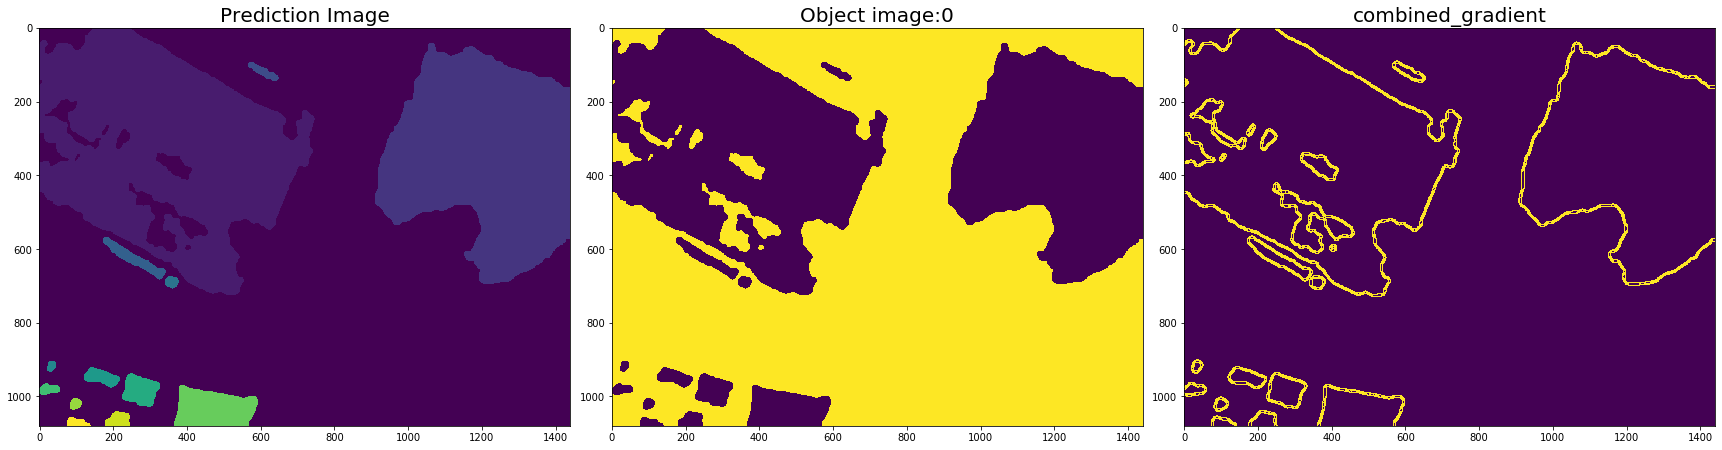

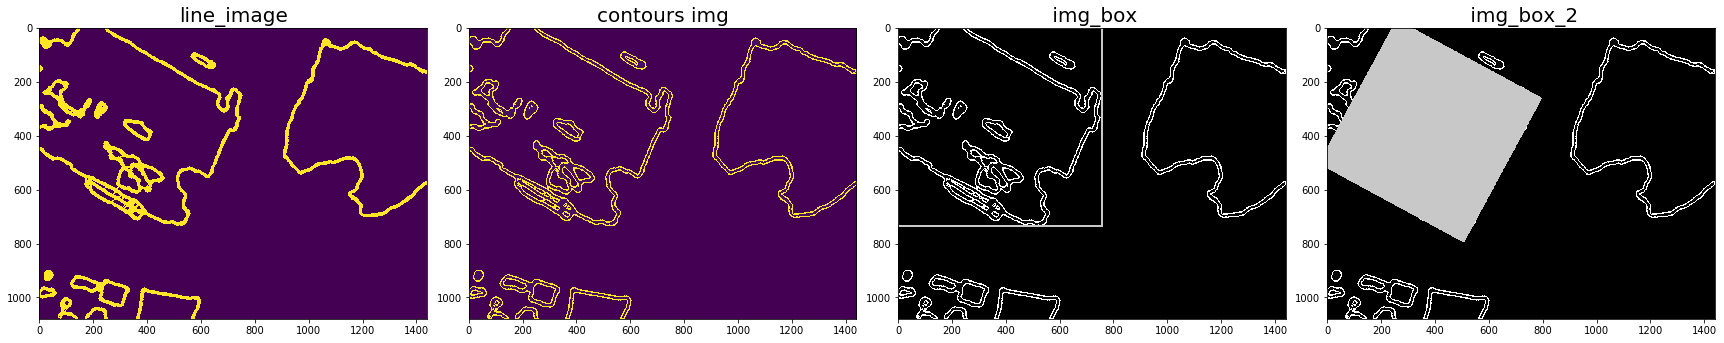

1


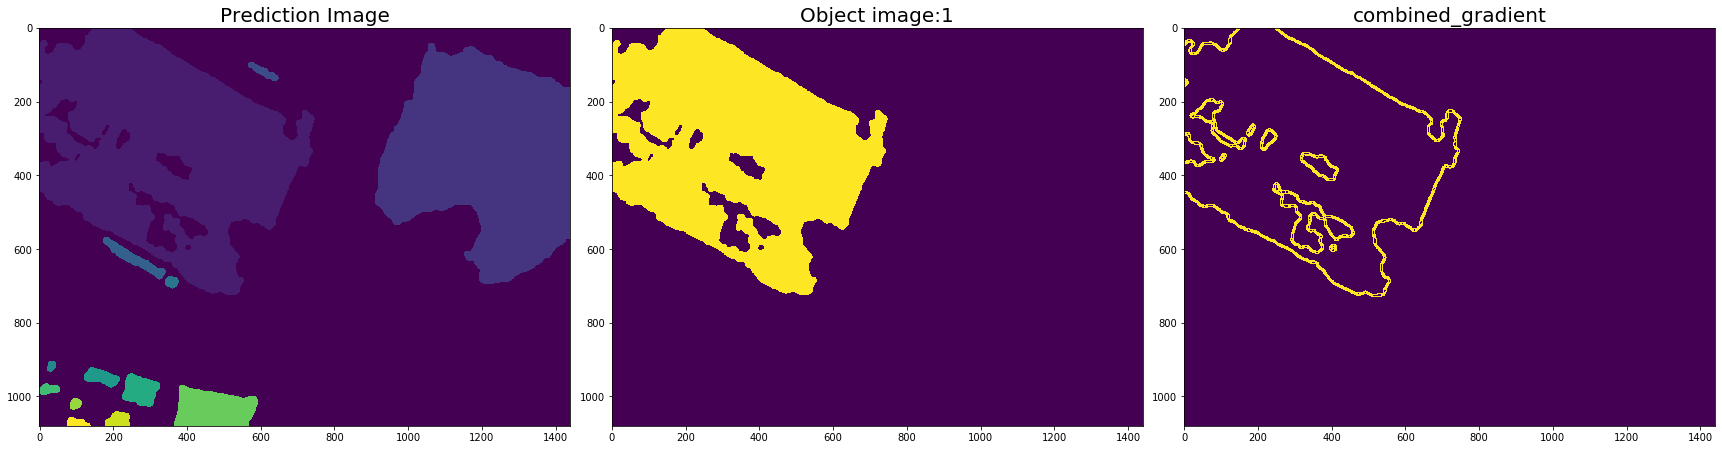

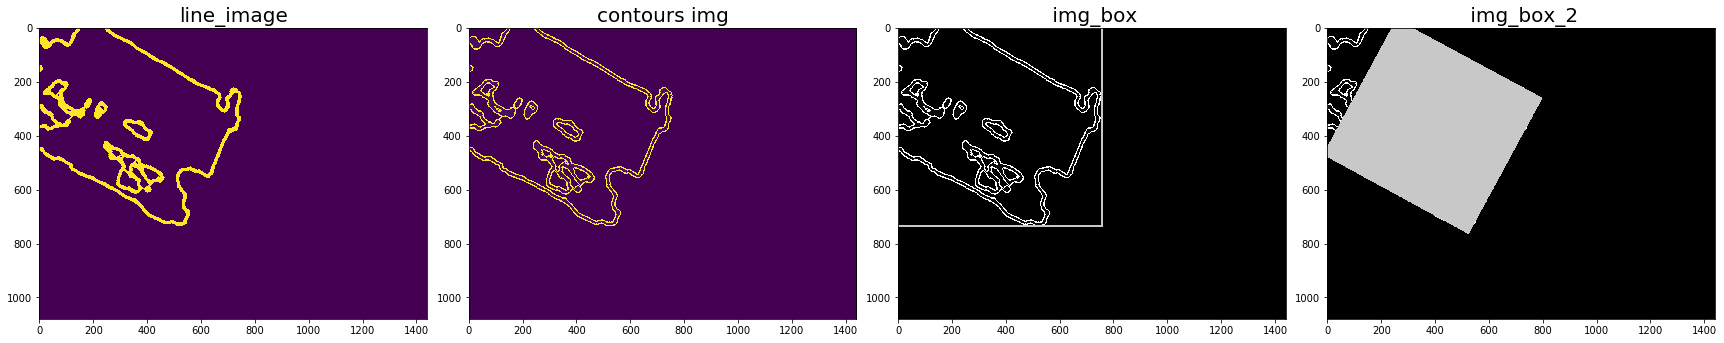

2


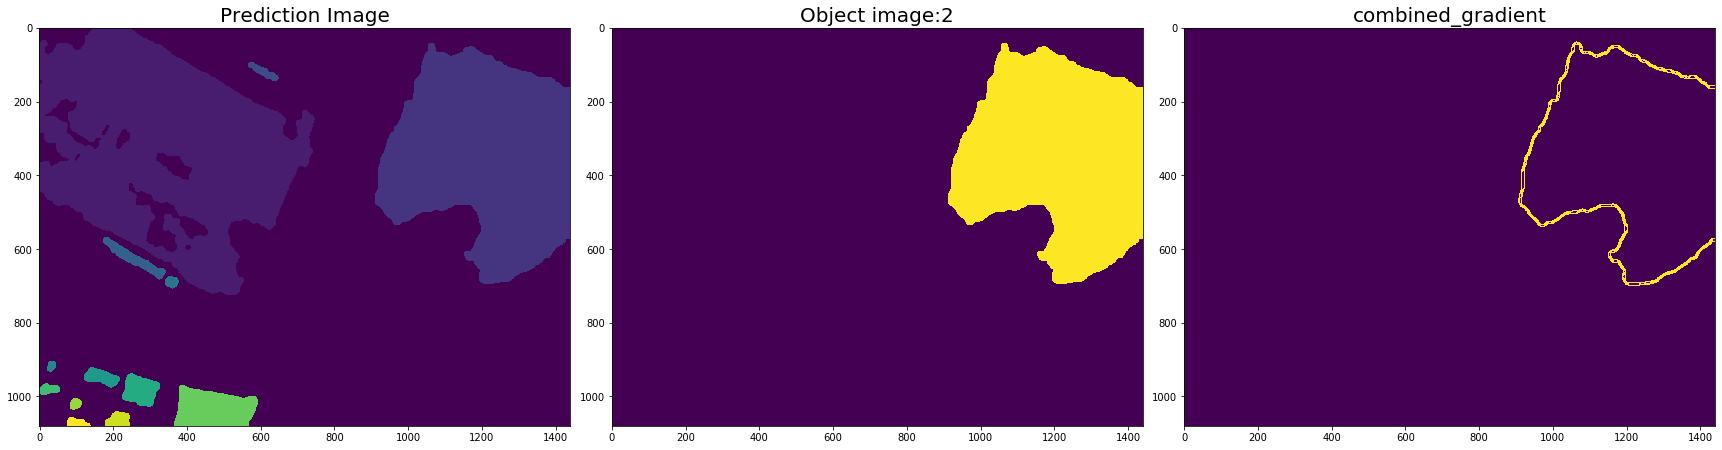

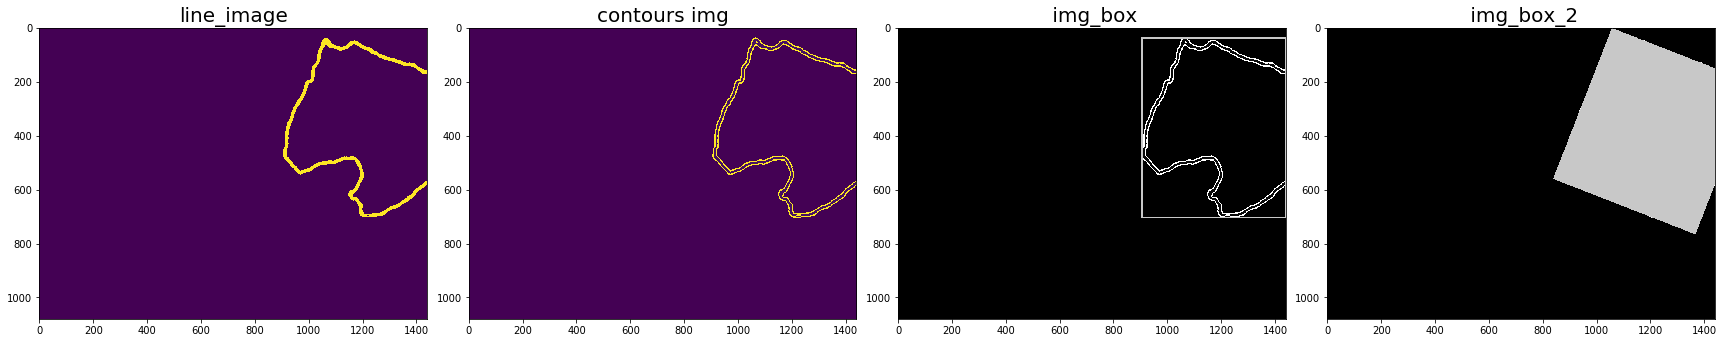

3


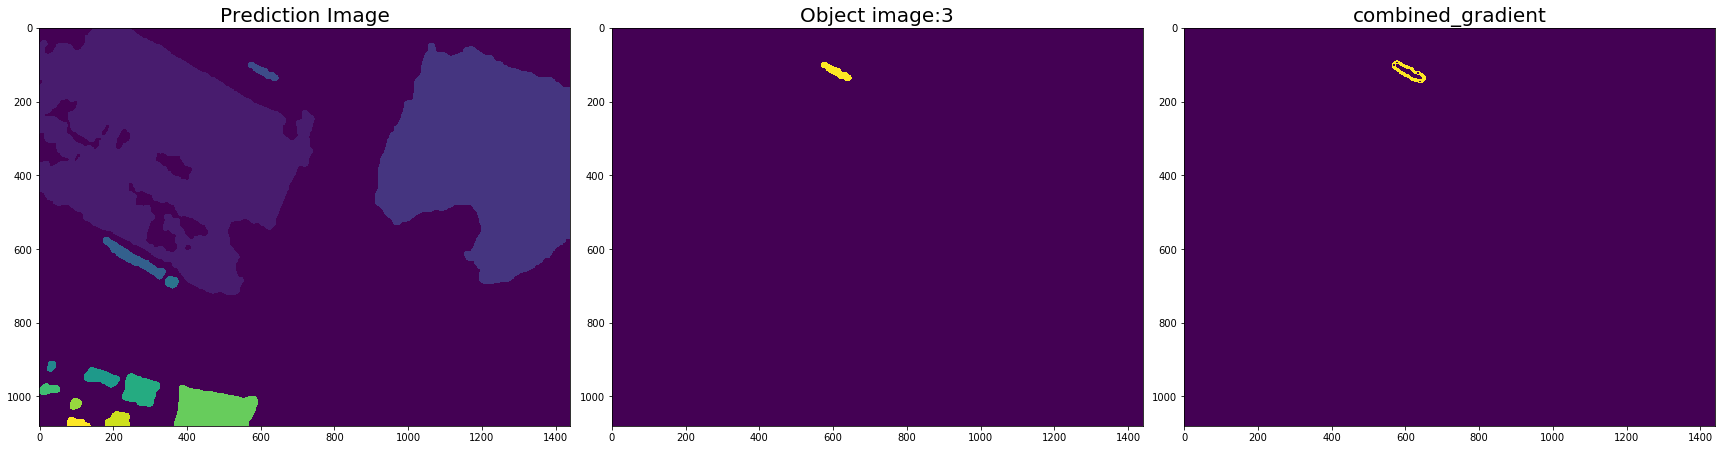

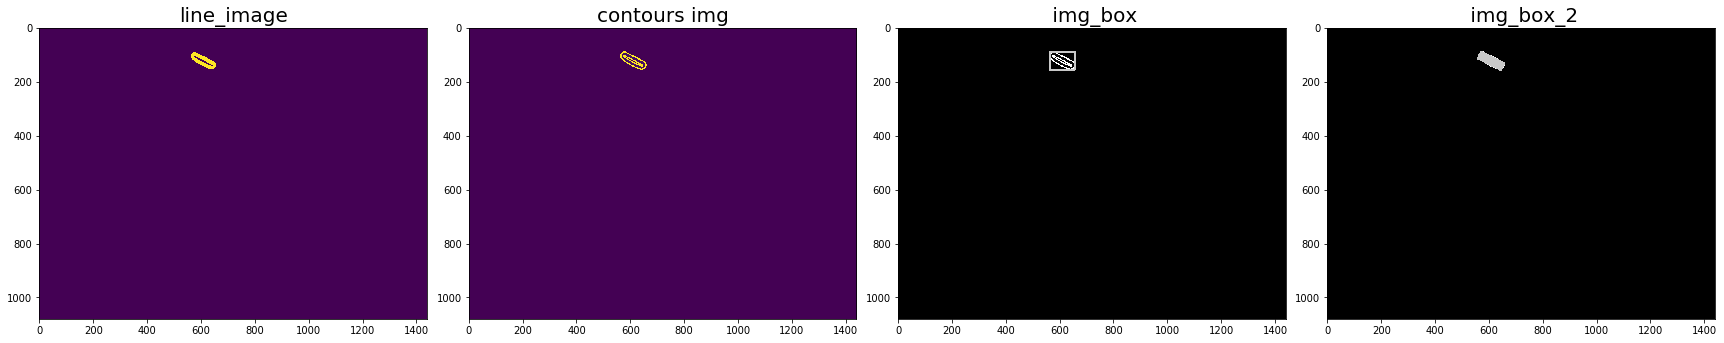

4


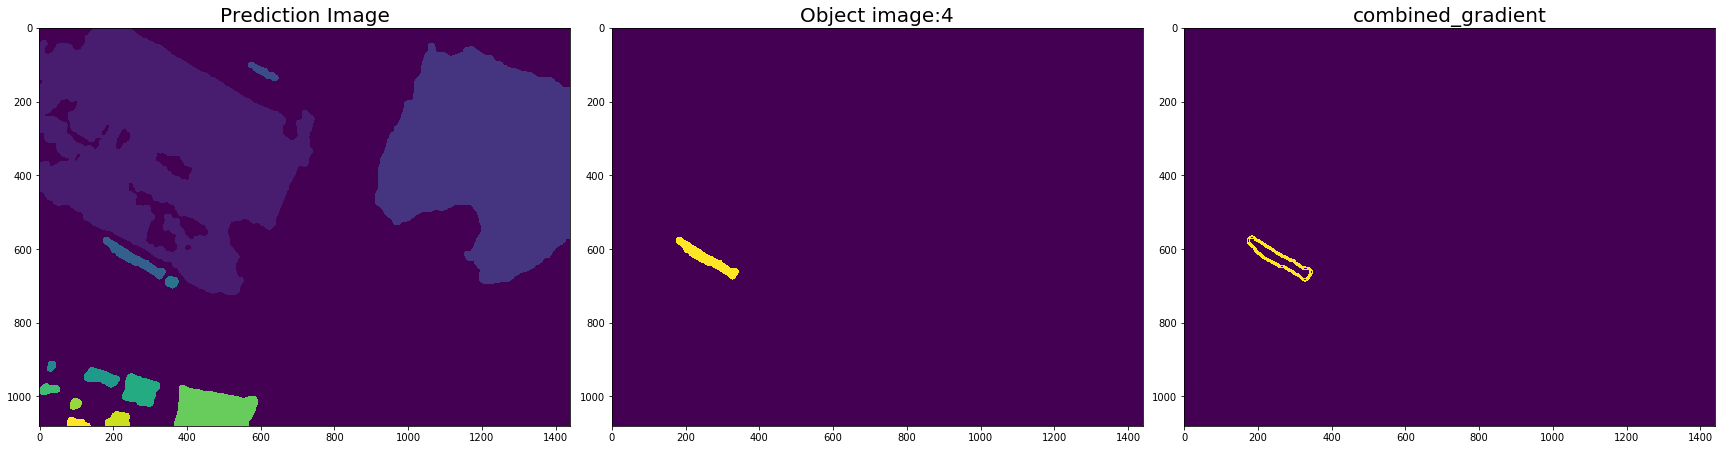

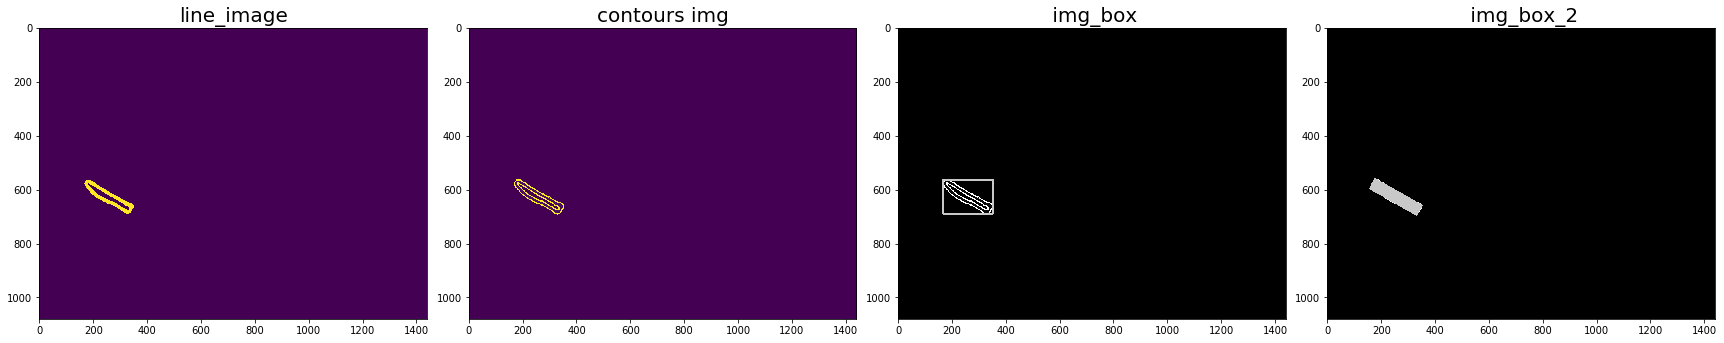

5


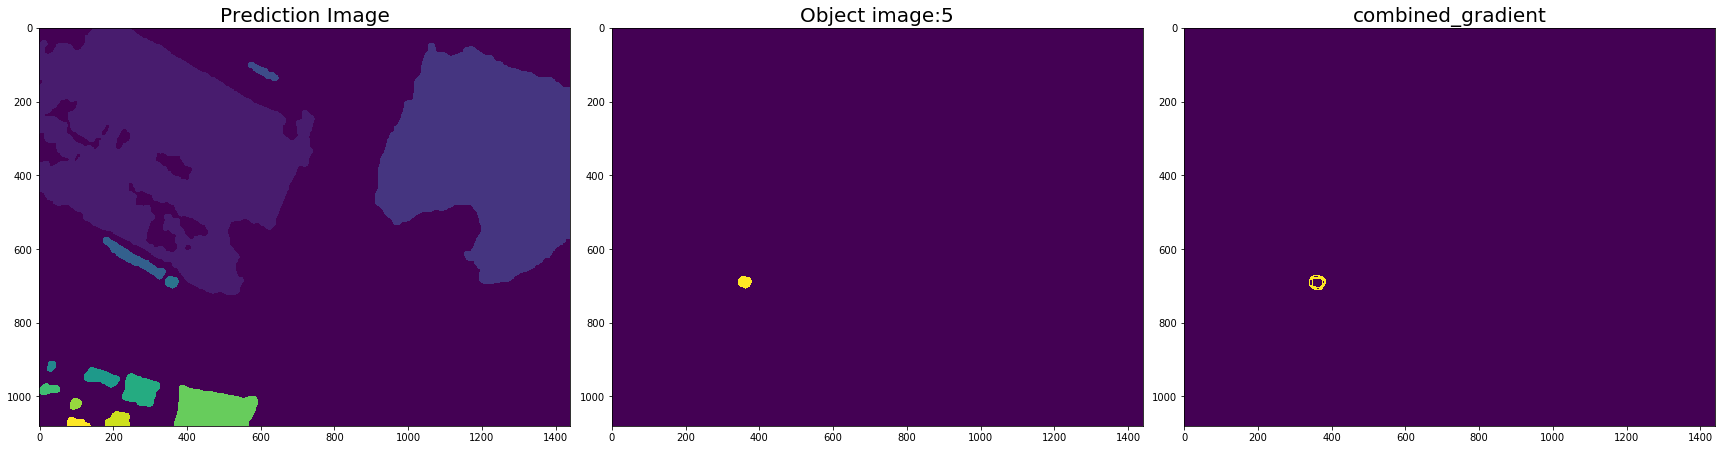

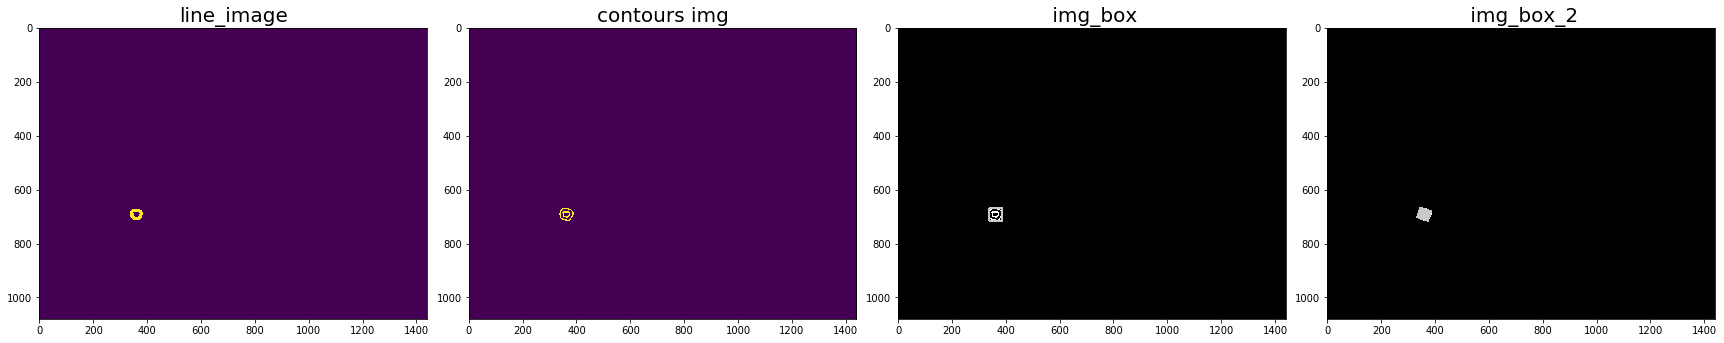

6


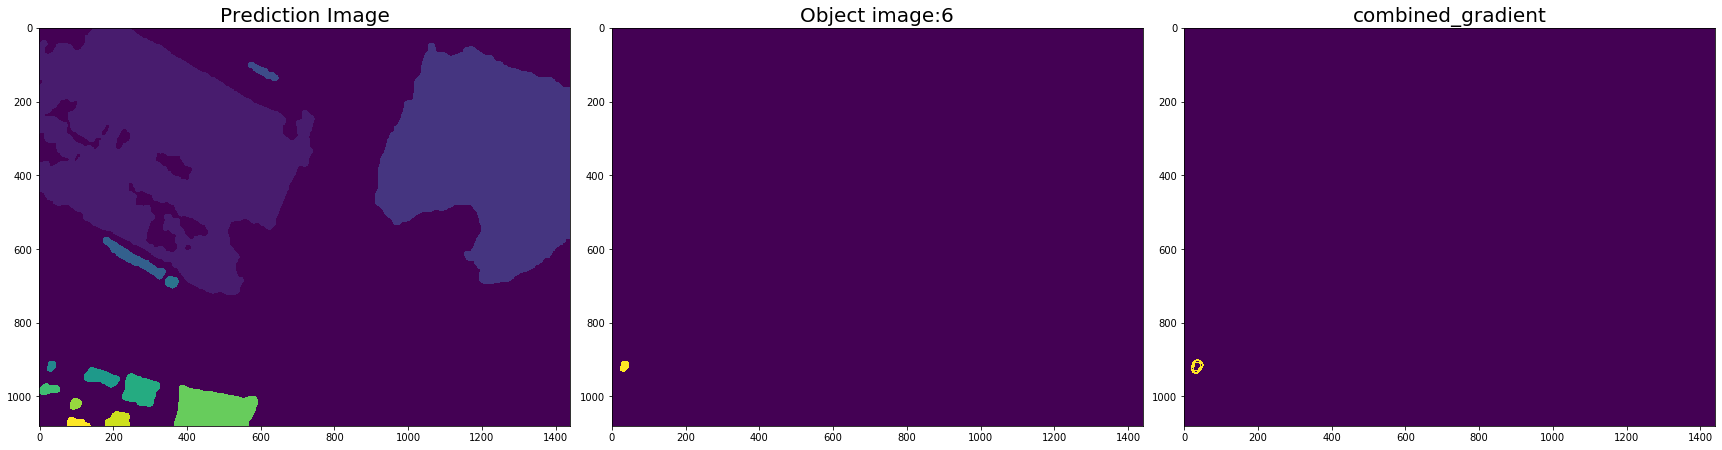

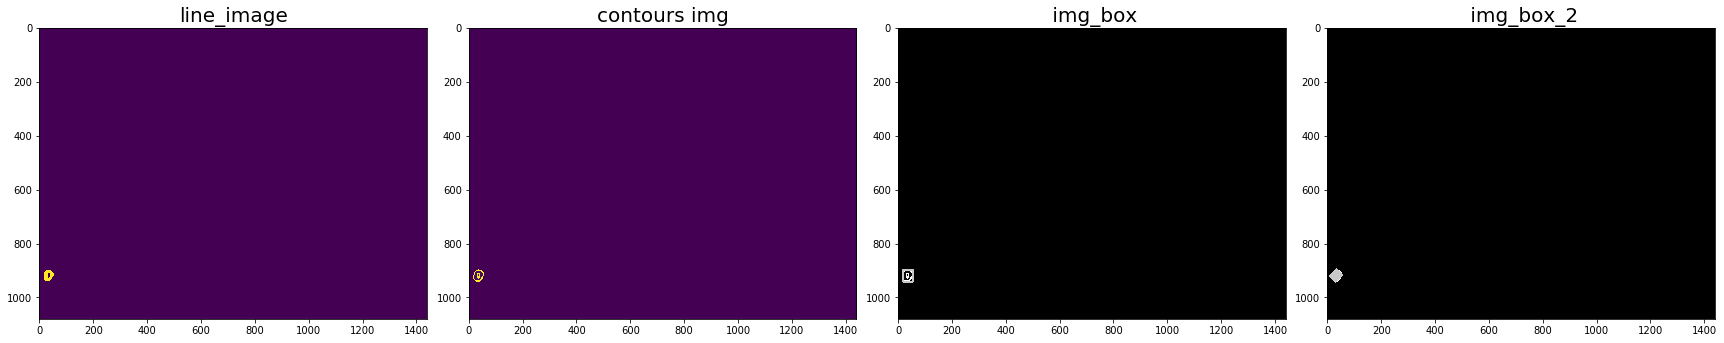

7


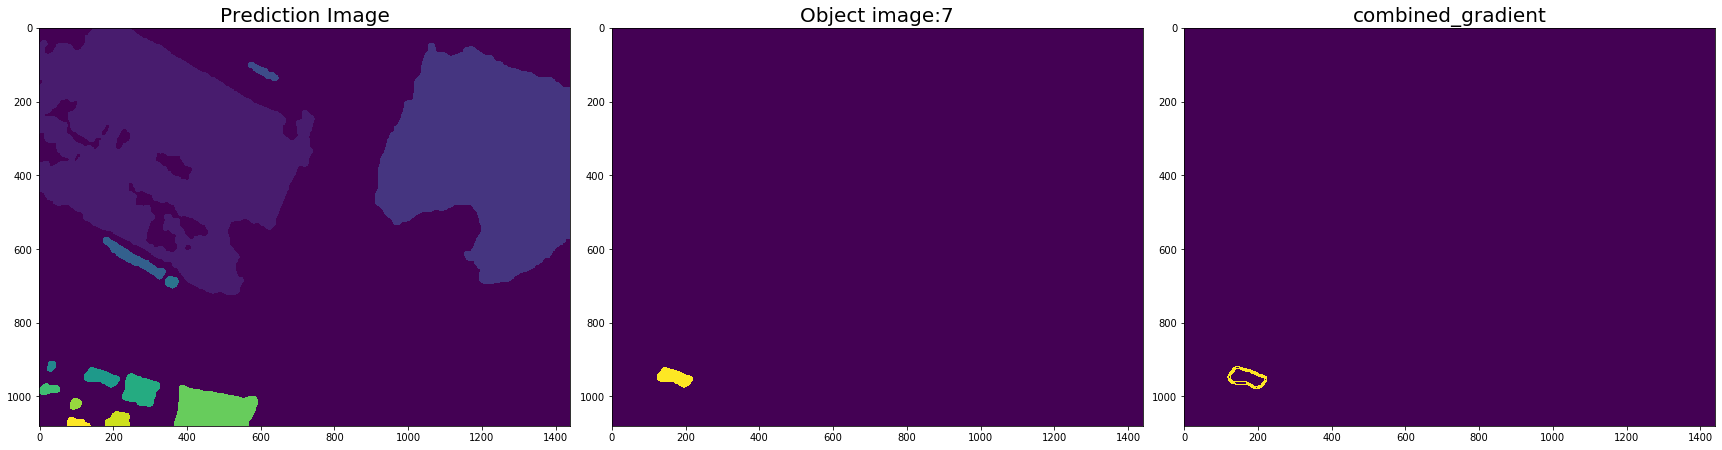

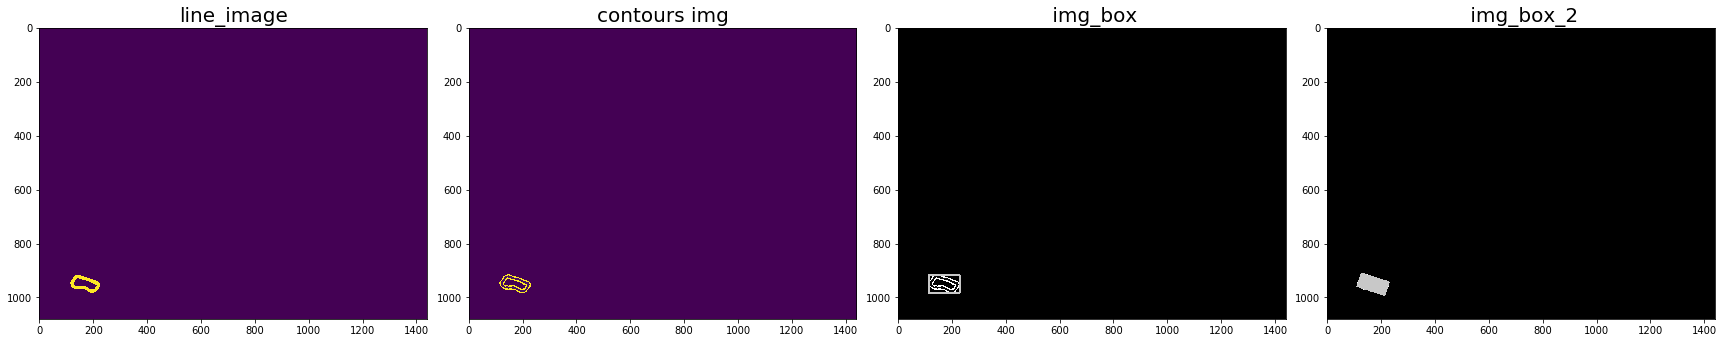

8


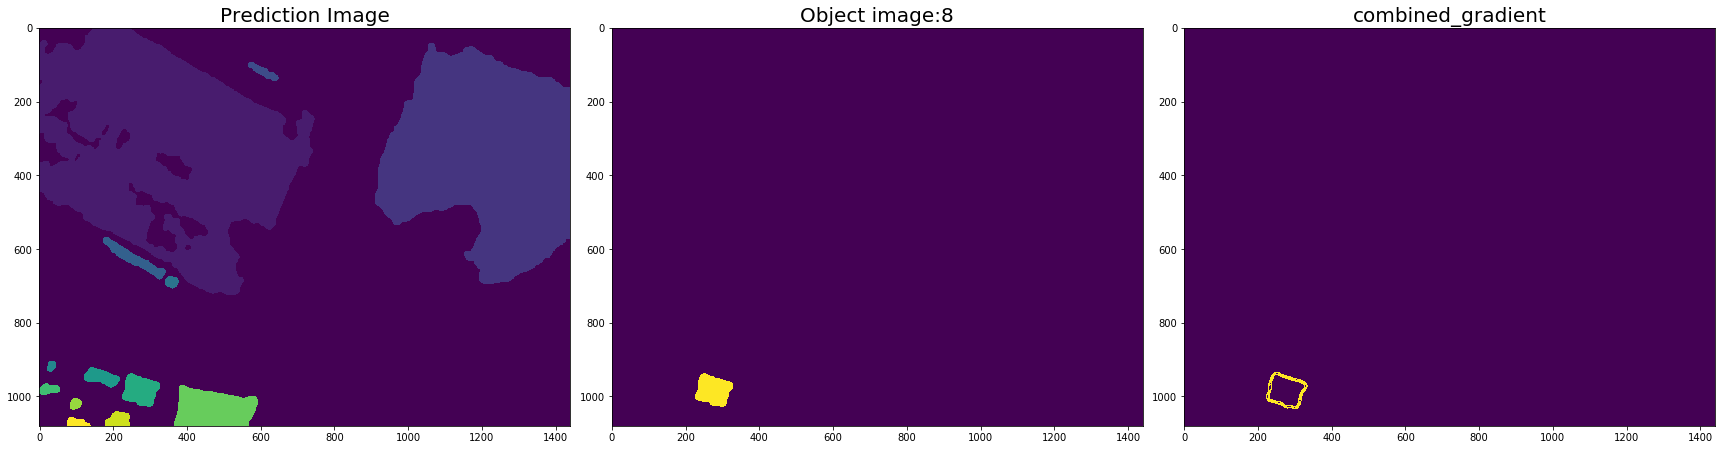

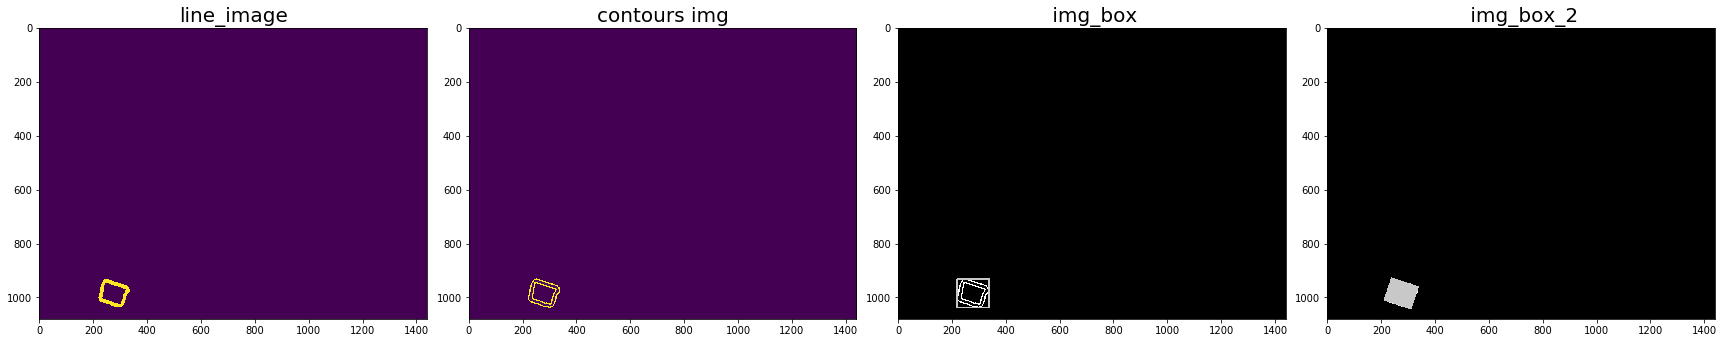

9


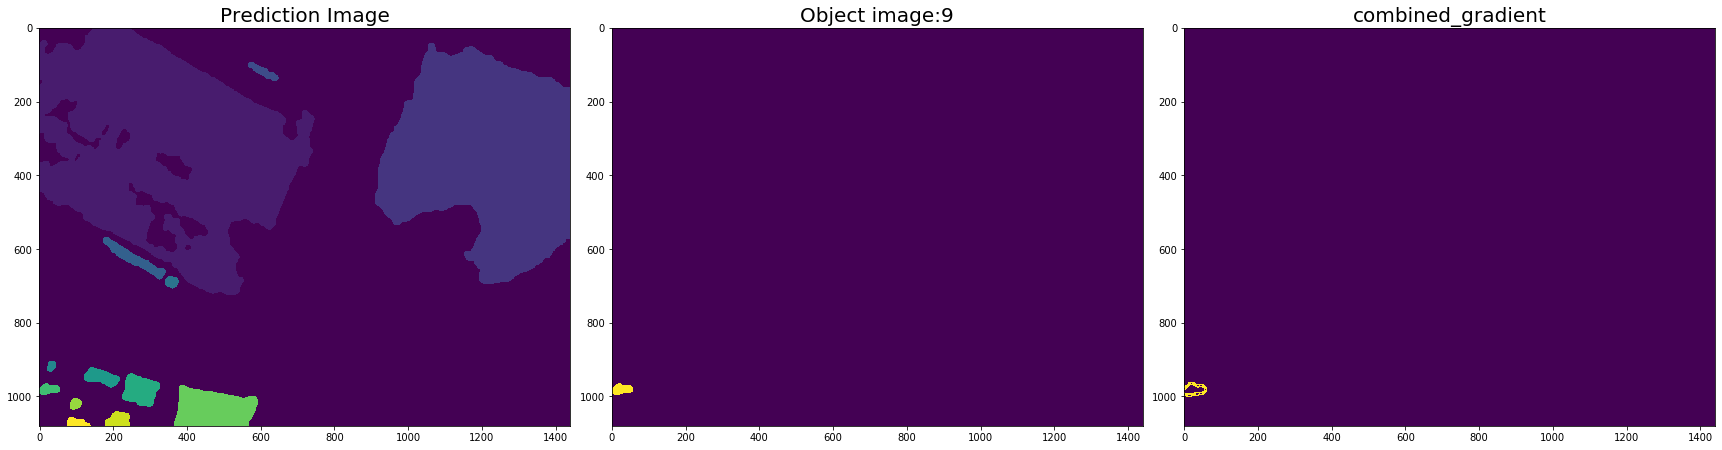

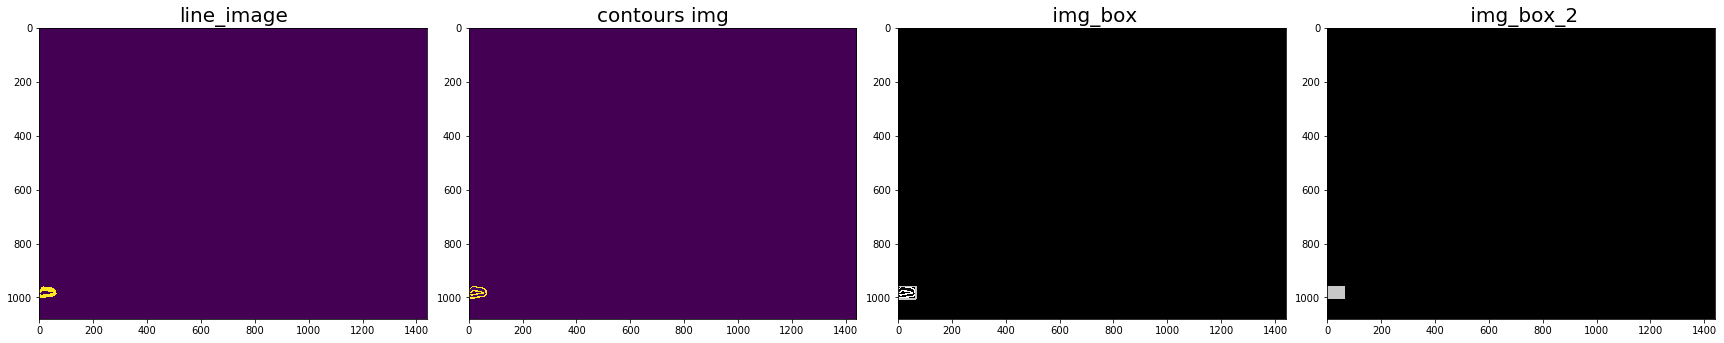

10


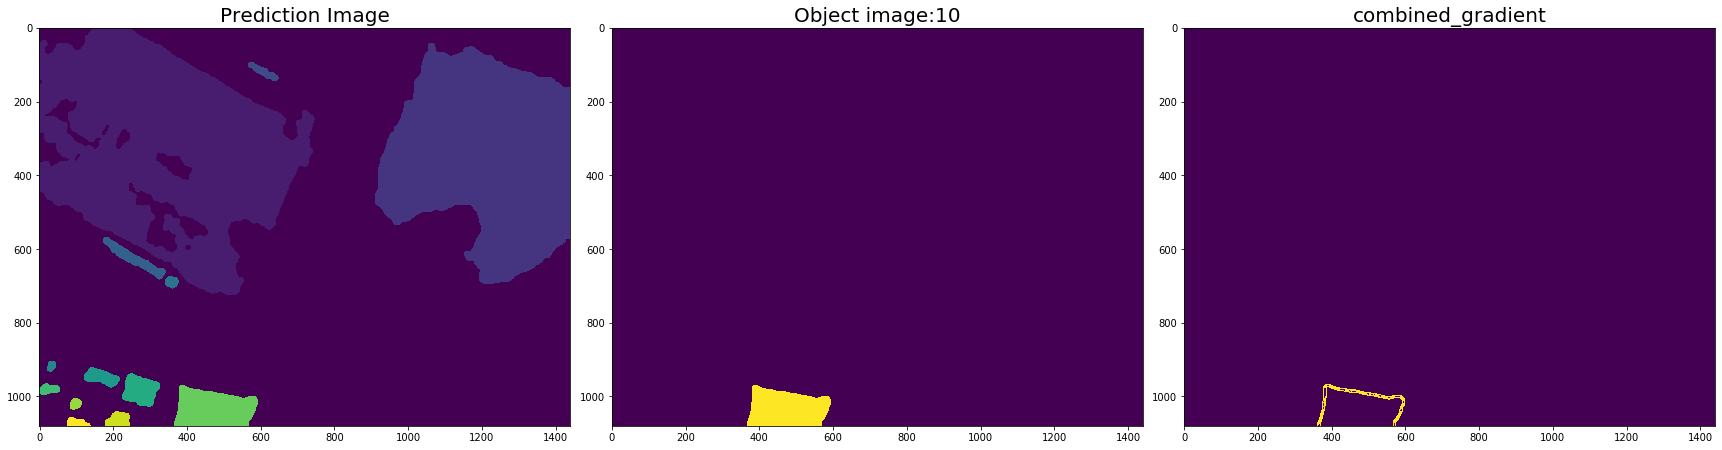

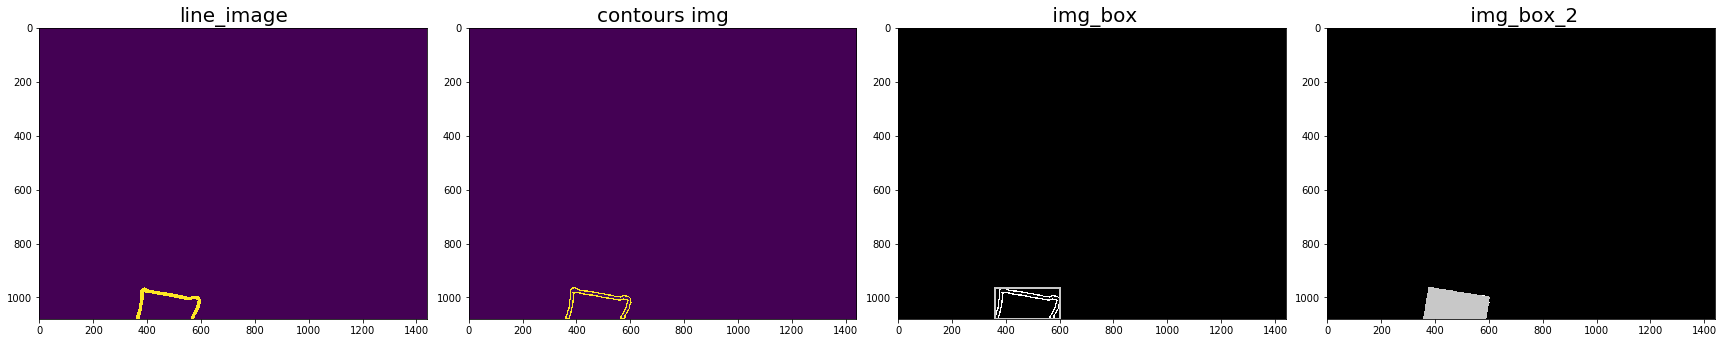

11


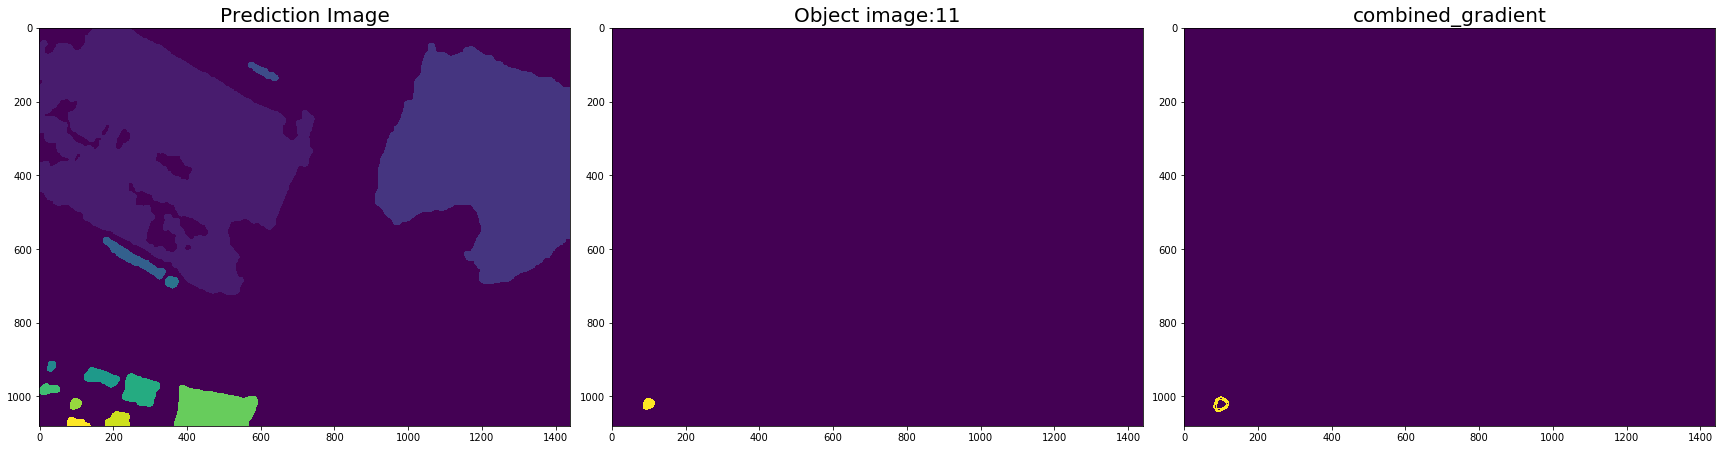

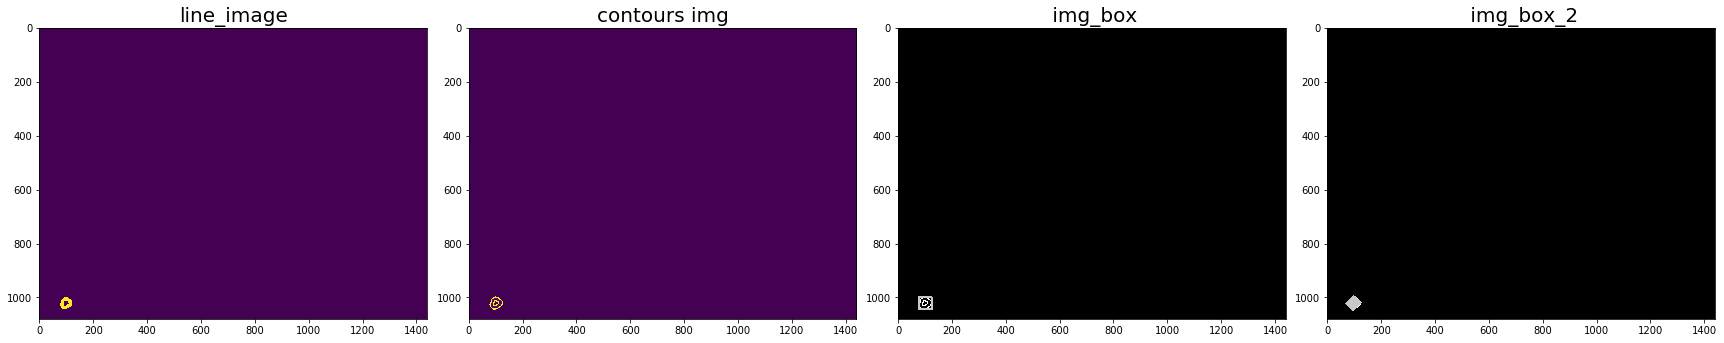

12


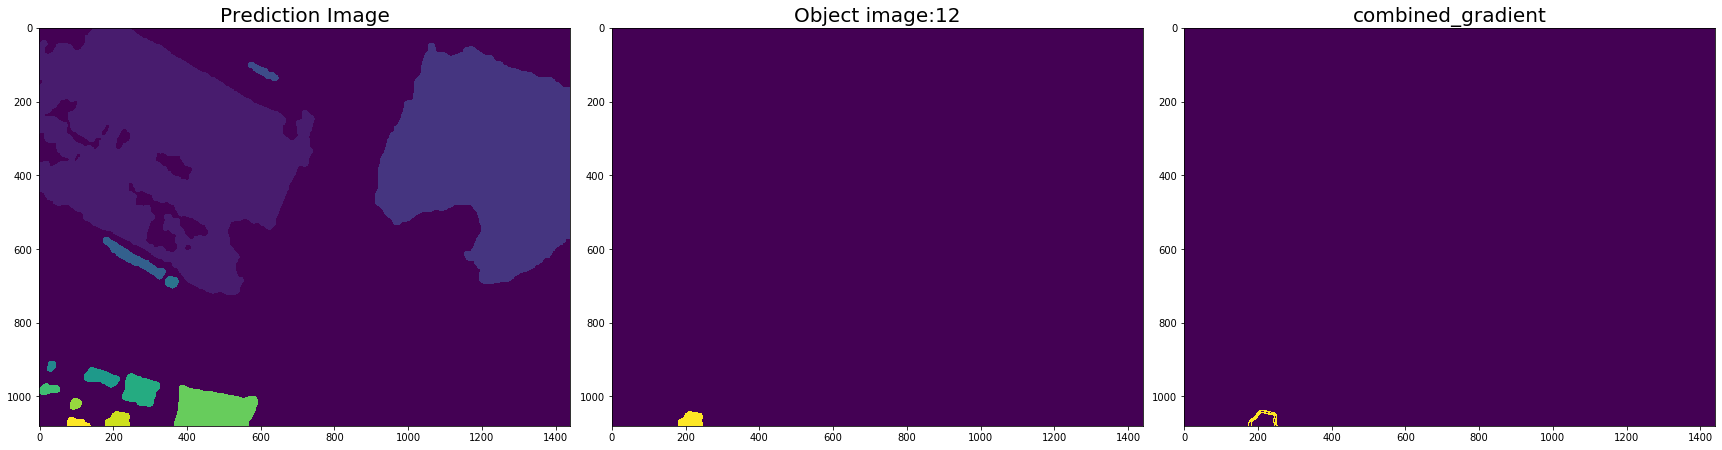

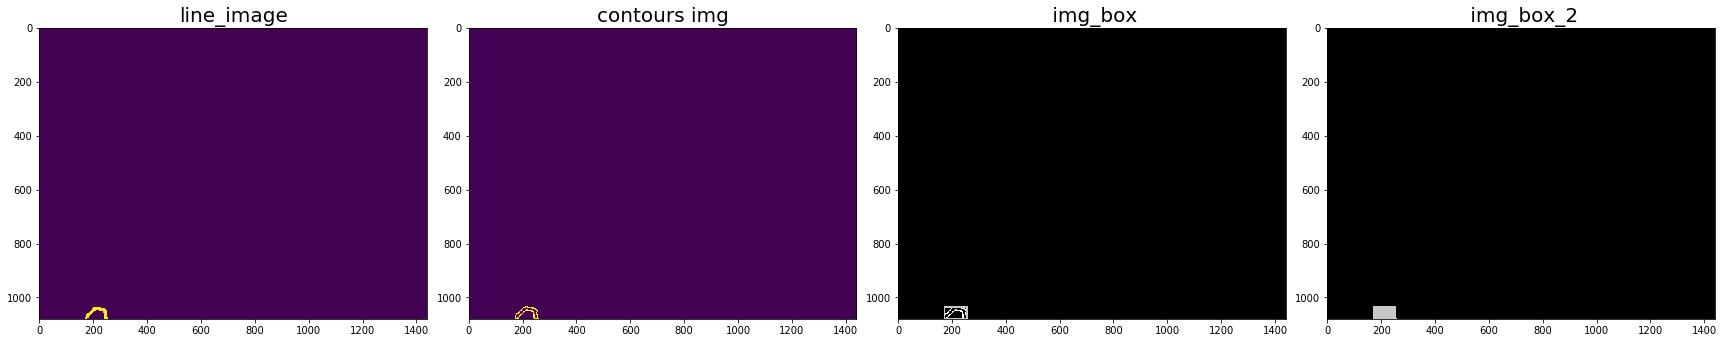

13


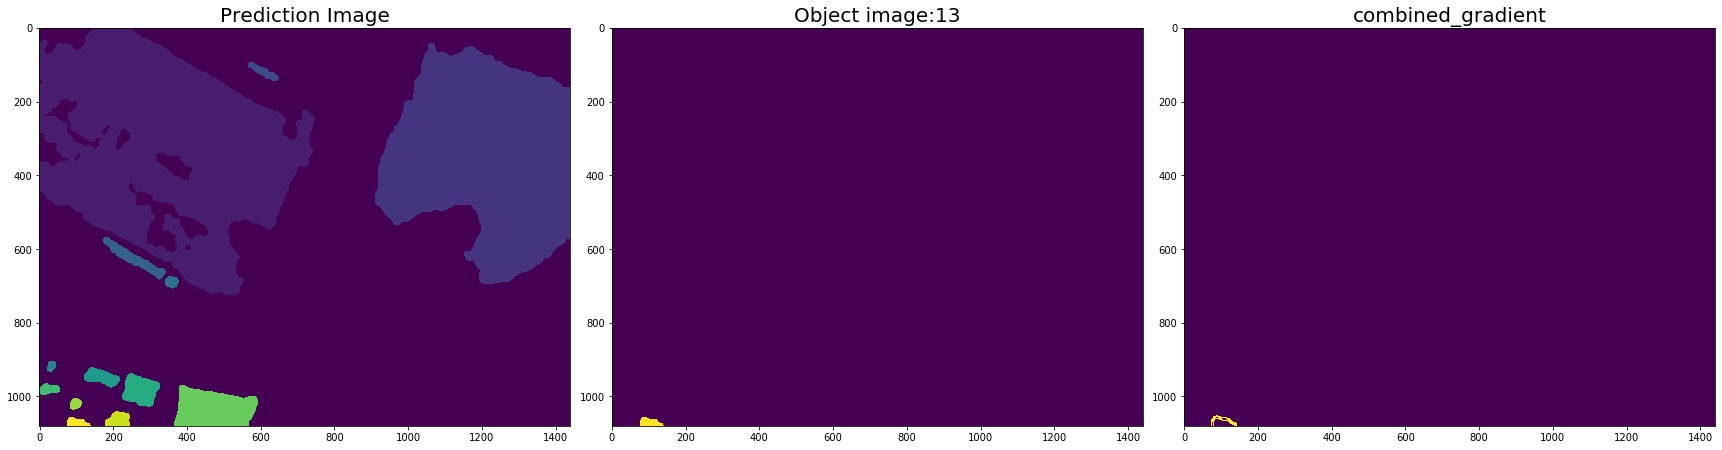

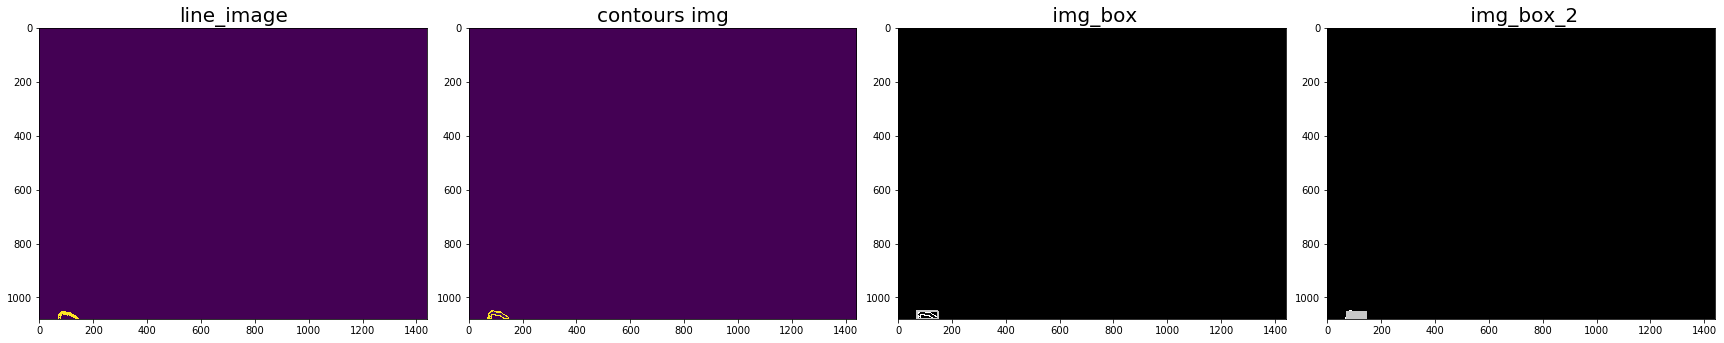

In [9]:
final_img=np.zeros_like(Close)

for i in range(len(number_of_objects)):
    objimg=np.zeros_like(Close)
    print(i)
    

    objimg[blob_labels==i]=1
    BFilter=BilateralFilter(objimg, 7,75,75)
    Close=Closing(BFilter,2)

    gradx=Abs_sobel_thresh(Close,orient='x',thresh=(40,214) ,sobel_kernel=25)
    grady=Abs_sobel_thresh(Close,orient='y',thresh=(40,214) ,sobel_kernel=25)
    mag_binary=Mag_thresh(Close, sobel_kernel=3, mag_thresh=(60, 200))
    dir_binary=Dir_threshold(Close, sobel_kernel=3, thresh=(.45, .90))
    combined_gradient=Combined_thresholds(gradx,grady,mag_binary,dir_binary)
    
    
    
    lines=DrawLine(combined_gradient)
    line_image=Display_lines(np.copy(combined_gradient),lines)
    contours_img,contours=ExtractandDrawContours(line_image.astype(np.uint8))
    img_box,img_box_2=drawBBOX(contours,contours_img)
    if (i!=0):
        final_img = cv2.addWeighted(final_img, 1, img_box_2, 1, 0) 
    
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,19))
    f.tight_layout()
    
    ax1.imshow(blob_labels)
    ax1.set_title('Prediction Image',fontsize=20)
    
    ax2.imshow(blob_labels==i)
    ax2.set_title('Object image:'+str(i),fontsize=20)
    
    ax3.imshow(combined_gradient)
    ax3.set_title('combined_gradient',fontsize=20)

    
    f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,19))
    f.tight_layout()
    
    ax1.imshow(line_image)
    ax1.set_title('line_image',fontsize=20)
    
    ax2.imshow(contours_img)
    ax2.set_title('contours img',fontsize=20)


    ax3.imshow(img_box, cmap='gray')
    ax3.set_title(' img_box', fontsize=20)
    
    ax4.imshow(img_box_2, cmap='gray')
    ax4.set_title(' img_box_2', fontsize=20)
    

   
    plt.pause(1)

Text(0.5, 1, 'Polygonization  Image')

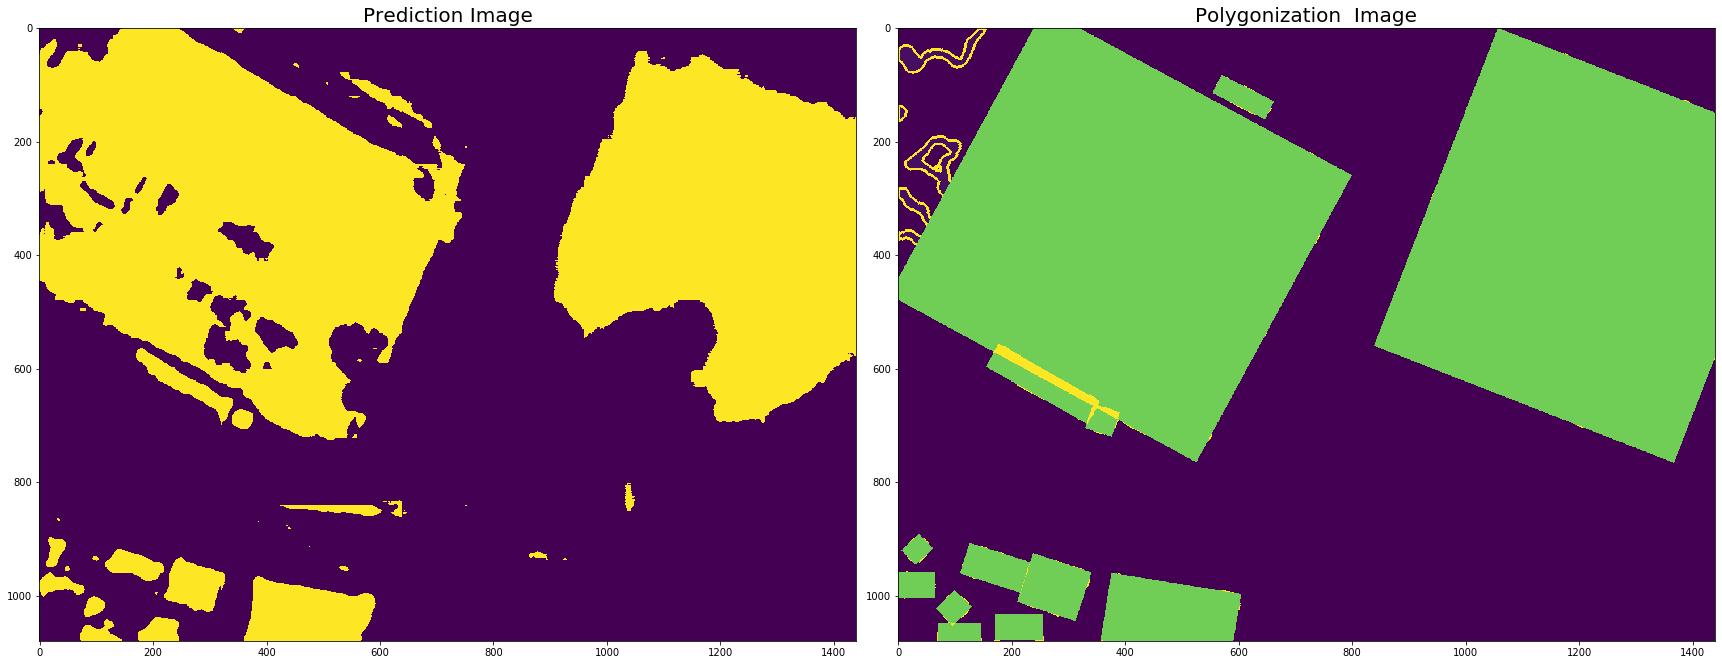

In [16]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,19))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Prediction Image',fontsize=20)

ax2.imshow(final_img)
ax2.set_title('Polygonization  Image',fontsize=20)

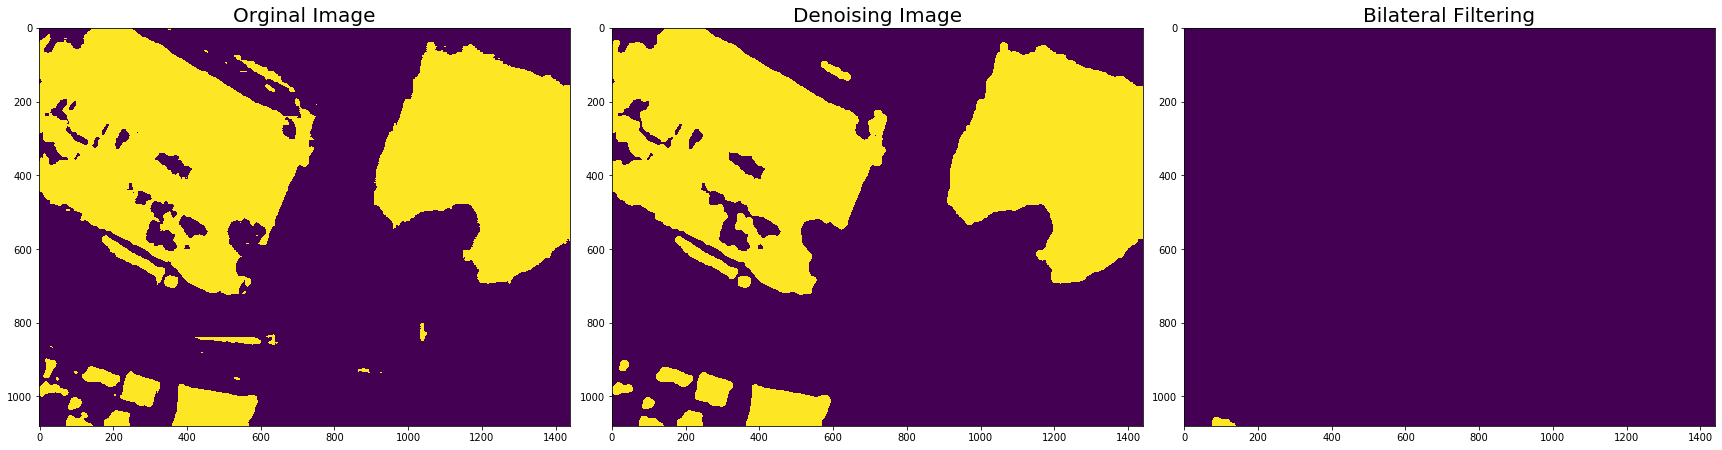

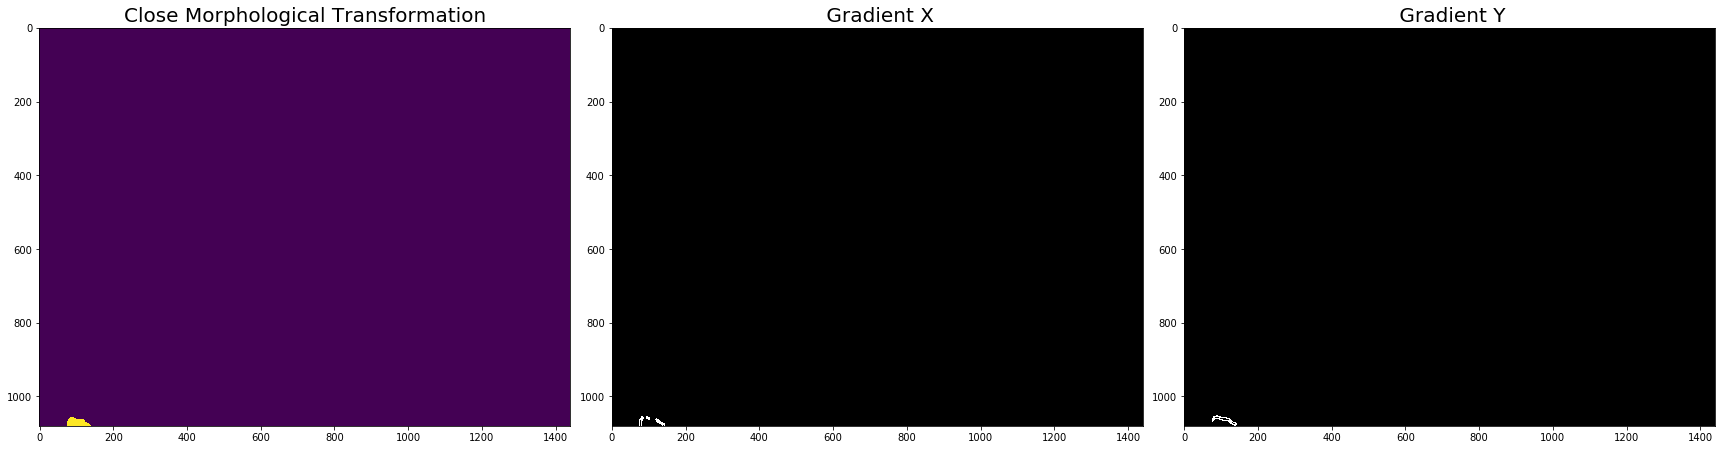

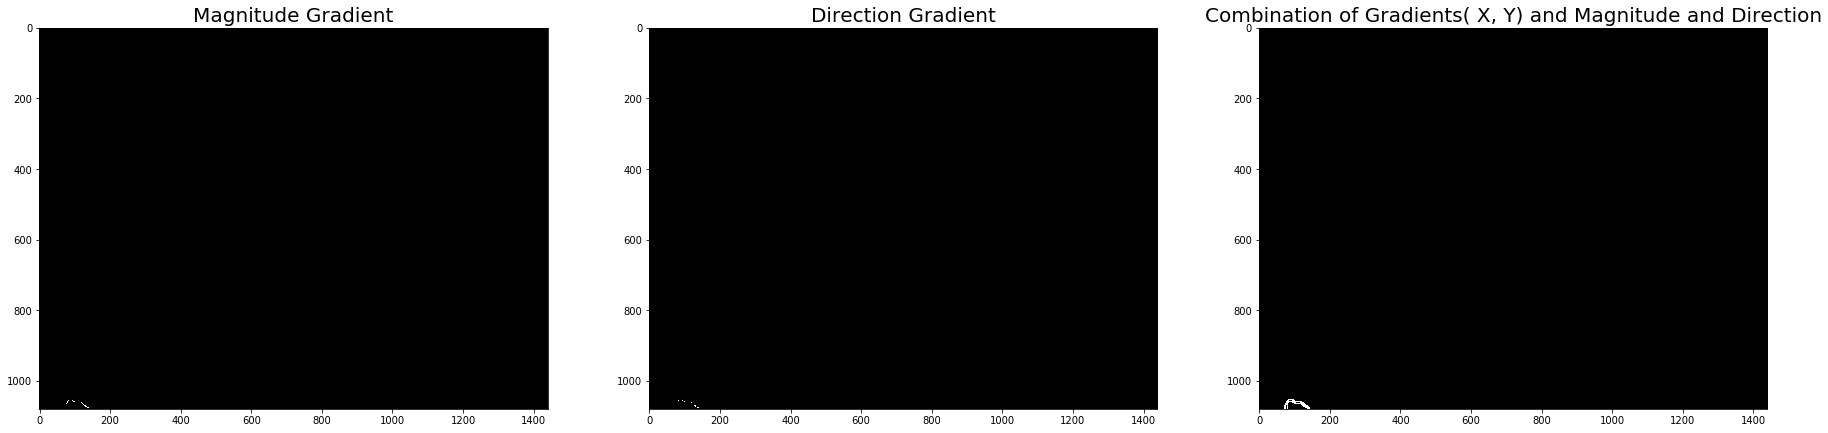

In [17]:
# Plot the result


f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,19))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Orginal Image',fontsize=20)

ax2.imshow(denoising)
ax2.set_title('Denoising Image',fontsize=20)

ax3.imshow(BFilter)
ax3.set_title('Bilateral Filtering',fontsize=20)


f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 19))
f.tight_layout()
ax1.imshow(Close)
ax1.set_title('Close Morphological Transformation',fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title(' Gradient X', fontsize=20)
ax3.imshow(grady, cmap='gray')
ax3.set_title(' Gradient Y', fontsize=20)

f, (ax4,ax5,ax6) = plt.subplots(1, 3, figsize=(24, 19))

ax4.set_title('Magnitude Gradient', fontsize=20)
ax4.imshow(mag_binary, cmap='gray')
ax5.set_title('Direction Gradient', fontsize=20)
ax5.imshow(dir_binary, cmap='gray')
ax6.set_title('Combination of Gradients( X, Y) and Magnitude and Direction', fontsize=20)
ax6.imshow(combined_gradient, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [10]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import  display

def interactive_mask(ksize,x_low,x_high,y_low,y_high,mag_low,mag_high,dir_low,dir_high):
    
    denoising=Denoise(img1,10)
    BFilter=BilateralFilter(denoising, 7,75,75)
    Close=Closing(BFilter,4)
    

    gradx=Abs_sobel_thresh(Close,orient='x',thresh=(x_low,x_high) ,sobel_kernel=ksize)
    grady=Abs_sobel_thresh(Close,orient='y',thresh=(y_low,y_high) ,sobel_kernel=ksize)
    mag_binary=Mag_thresh(Close, sobel_kernel=3, mag_thresh=(mag_low,mag_high))
    dir_binary=Dir_threshold(Close, sobel_kernel=3, thresh=(dir_low,dir_high))
    combined_gradient=Combined_thresholds(gradx,grady,mag_binary,dir_binary)

    #HLScolor_binary=HLScolor(img_undist, s_thresh= (hls_low,hls_high))
    #combined_thresholds_color1=combined_thresholds_color(combined_gradient,HLScolor_binary)

    #LUVcolor_binary=LUVcolor(img_undist, thresh= (luv_low,luv_high))
    #combined_thresholds_color2=combined_thresholds_color(combined_thresholds_color1,LUVcolor_binary)



    #LABcolor_binary=LUVcolor(img_undist, thresh= (lab_low,lab_high))
    #combined_thresholds_color3=combined_thresholds_color(combined_thresholds_color2,LABcolor_binary)

    #RGBcolor_binary=RGBcolor(img_undist, thresh= (rgb_low,rgb_high))
    #combined_thresholds_color4=combined_thresholds_color(combined_thresholds_color3,RGBcolor_binary)

    plt.figure(figsize=(10,10))
    plt.imshow(combined_gradient,cmap='gray')
    #return combined_gradient


C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [11]:
interact(interactive_mask,ksize=(1,31,2),x_low=(0,255),x_high=(0,255),y_low=(0,255),y_high=(0,255),\
         mag_low=(0,255),mag_high=(0,255),dir_low=(0,np.pi/2),dir_high=(0,np.pi/2))

interactive(children=(IntSlider(value=15, description='ksize', max=31, min=1, step=2), IntSlider(value=127, de…

<function __main__.interactive_mask(ksize, x_low, x_high, y_low, y_high, mag_low, mag_high, dir_low, dir_high)>